In [1]:
import numpy as np
from timeit import timeit as timeit
import os
import matplotlib.pyplot as plt
import subprocess
from joblib import Parallel, delayed
import multiprocessing 
import pandas as pd

# Expérimentation sur SMC++

Les différentes **parties** du notebook sont  qu'on est suivi est le suivant: <br/> <br/>
<font size="4">
    <b>
    I - Formatage des données <br/>
    II - Prédictions <br/>
    III - Partie Adygei <br/>
    IV - MSE <br/>
    V - Comparaison VCF et SMC <br/>
    VI - Evaluation de SMC++ <br/>
    VII - Estimations de scenarios et différents tests
    </b>    
</font>        
<br/>
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# **I - Formatage des données**

## **Conversion du format SNP vers SMC**
Dans cette partie on commence par créer un **convertiseur** d'une matrice SNP et positions vers le format SMC.<br />
Dans les deux fonctions on va juste gérer les colonnes ( données )

In [2]:
def SNPtoSMC(dist, SNP, POS):
    """
    dist : id de l'individu distingué
    SNP : matrice de SNPs
    POS : postions de la matrice de SNPs
    return : une matrice au format SMC
    """
    N = SNP.shape[0]
    M = POS.shape[0]
    N = N if N%2 == 0 else N - 1
    SNP = SNP[:N]
    # on remplace les 0 de la matrice de position par des 1
    POS[POS == 0] = 1
    assert dist < N/2
    
    dist *= 2
    SMC = np.zeros((2*M,4), dtype=int)
    SMC[:,-1] = N*np.ones(2*M, dtype=int) - 2
    SMC[:, 0] = np.ones(2*M, dtype=int)
    d = SNP[dist, :] + SNP[dist+1, :]
    u = np.sum(SNP, axis=0, dtype=int) - d
    SMC[1::2, 1:-1] = np.transpose([d, u]) 
    SMC[0::2, 0:-1] = np.transpose([POS - 1, np.zeros(M, dtype=int), np.zeros(M, dtype=int)])
    todelete = np.argwhere(POS <= 1).transpose()*2
    # cas extrèmes
    for i in todelete[0,:]:
        if (SMC[i-1] == SMC[i+1]).all():
            SMC[i-1, 0] += SMC[i+1, 0]
            todelete = np.append(todelete, [[i+1]])
    # il y a un dernier problème :
    # si un 1 est remplacé par un 2,il y aura forcément un décalage
    return np.delete(SMC, todelete, 0)

### **Fonctions de manipulation de fichiers**

Ces fonctions permettent le charger et de manipuler différents fichiers

In [3]:
def loadCSV_plot(file):
    """
    File: c'est le chemin d'un fichier plot
    
    @return : On renvoie les deux colonnes correspondant à:
    X : Le nombre de générations
    Y : taille de la population
    """
    smcData = pd.read_csv(file, sep=',')
    X = smcData['x'].to_numpy()
    Y = smcData['y'].to_numpy()
    return X, Y
    
def loadCSV_subsample(scenario = "11687", dist = 0):
    """
    load true data from csv and estimated data from out/    
    """
    trueData = np.genfromtxt('hdgp_demo_parameters_subsample.csv',delimiter=',', dtype=int)
    trueX = trueData[1,6:27]
    ids = np.argwhere(trueData[:,0] == scenario)
    trueY = trueData[ids,27:].flatten()
    
    file = f'out/scenario_{scenario}/dist_{dist}/plot.csv'
    smcData = pd.read_csv(file)
    smcX = smcData['x'].to_numpy()
    smcY = smcData['y'].to_numpy()
    return trueX, trueY, smcX, smcY

def loadfile(scenario, i, path="hdgp/scenario_",form=".npz"):
    """
    Fonction permettant de charger nos données au format d'entrainrement principalement
    """
    file_name = path + scenario +"/hdgp_" + scenario + "_" + str(i) + form
    print(file_name)
    data = np.load(file_name)
    return data

Le les fichiers SMC ont besoin d'un header qui décrit la version du logiciel, une liste des individus distingués et une liste des individus non distingués.
On crée alors une fonction qui prend en paramèmtre l'identifiant de la population considérée, l'individu distingué et le nombre total d'individus.
La fonction renvoie le header correspondant.

In [4]:
def header_smc(pid, dist, n_ind):
    """
    pid: id de la population considérée
    dist: individu distingué
    n_ind: nombre d'individus
    return: le header correspondant pour le format SMC
    """
    header = 'SMC++ {"version": "1.15.4.dev18+gca077da", "pids": ["'+ pid +'"], "undist": [['
    for i in range(n_ind):
        if(i != dist):
            indid = pid + str(i)
            header += '["' + indid + '", 0], ["' + indid + '", 1], '
    indid = pid + str(dist)
    header = header[:-2] + ']], "dist": [[["' + indid +'", 0], ["' + indid + '", 1]]]}'
    return header

def generate_string_vcftosmc(pop, N):
    """
    pop: the name of the poppulation
    N: the number of individuals (not the number of chromosomes)
    return: the string to use in the command vcf2smc
    """
    string = f"{pop}:"
    for i in range(N):
        string += f"{pop}_{i},"
    return string[:-1]

In [5]:
## test sur un exemple simple
def test():
    snp = np.array([
    [0, 0, 1, 1],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    ])
    pos = np.array([3, 5, 1, 9])
    print(SNPtoSMC(0, snp, pos))
    print(SNPtoSMC(1, snp, pos))
    print(SNPtoSMC(2, snp, pos))
    print(snp)
    print(pos)
#test()

In [6]:
## mesure du temps prise par la fonction SNPtoSMC
n = 1000
data = loadfile(scenario="6", i="5")
SMC = SNPtoSMC(0, data['SNP'], data['POS'])
print(SMC[:10])
time = timeit("SNPtoSMC(0, data['SNP'], data['POS'])", globals=globals(), number=n)/n
print(f"\nSNPtoSMC exec time {time:.5f}s")

print(f"Nombre de 0 dans la matrice de position : {np.sum(data['POS'] == 0)}")
assert (SMC[:, 0] > 0).any()

hdgp/scenario_6/hdgp_6_5.npz
[[ 320    0    0   34]
 [   1    1   17   34]
 [1091    0    0   34]
 [   1    0    3   34]
 [  54    0    0   34]
 [   1    1   17   34]
 [ 705    0    0   34]
 [   1    1    4   34]
 [ 210    0    0   34]
 [   1    0    2   34]]

SNPtoSMC exec time 0.00231s
Nombre de 0 dans la matrice de position : 19


Alors que la première fonction c'est juste pour un scénario en particulier sans compression et la deuxièmle avec compression. Ces deux fonctions font appel aux fonctions prcédentes, notamment les deux principales qui sont **`SNPtoSMC`** et **`header_smc`**   <br/>
La dernière fonction sert à générer tous les fichiers SMC pour toutes données. => **IL Y A DE LA PARALLELISATION !**

**Taile des données de sorties de la fonction all_scenarios:** 
* 15,1 Go **sans compression** (one_scenario_compressed)
* 2,31 Go **avec compression** (one_scenario)


In [7]:
def one_scenario(d="scenario_11687", save_dir="smc_files"):
    if save_dir not in os.listdir():
        os.mkdir(save_dir)
    for file in os.listdir("hdgp/" + d):
        # chargement des données
        data = np.load("hdgp/" + d + "/" + file)
        SNP, POS = data['SNP'], data['POS']
        # remplace tous les 0 de la matrice de positions par des 1
        POS[POS == 0] = 1 
        # on récupère le nombre d'individus (on le suppose pair)
        N = data['SNP'].shape[0]
        N = N if N%2 == 0 else N - 1
        # création du dossier du scénario
        scenario_dir = save_dir + "/" + d
        if d not in os.listdir(save_dir):
            os.mkdir(scenario_dir)
            
        for dist in range(0, int(N/2)):
            # pour chaque individu distingué, on crée un dossier qui contient les fichiers smc associés
            dist_dir = scenario_dir + "/" + "dist_" + str(dist)
            if "dist_" + str(dist) not in os.listdir(scenario_dir):
                os.mkdir(dist_dir)
            SMC = SNPtoSMC(dist, SNP, POS)
            filename = dist_dir + "/" + file + str(dist) + ".smc"
            header = header_smc("hdgp", dist, N)
            np.savetxt(filename , SMC, delimiter=' ', fmt = "%d", header=header)
            
def one_scenario_compressed (d="scenario_11687", save_dir="smc.gz_files"):
    if save_dir not in os.listdir():
        os.mkdir(save_dir)
    for file in os.listdir("hdgp/" + d):
        # chargement des données
        data = np.load("hdgp/" + d + "/" + file)
        SNP, POS = data['SNP'], data['POS']
        # remplace tous les 0 de la matrice de positions par des 1
        POS[POS == 0] = 1 
        # on récupère le nombre d'individus (on le suppose pair)
        N = data['SNP'].shape[0]
        N = N if N%2 == 0 else N - 1
        # création du dossier du scénario
        scenario_dir = save_dir + "/" + d
        if d not in os.listdir(save_dir):
            os.mkdir(scenario_dir)
            
        for dist in range(0, int(N/2)):
            # pour chaque individu distingué, on crée un dossier qui contient les fichiers smc associés
            dist_dir = scenario_dir + "/" + "dist_" + str(dist)
            if "dist_" + str(dist) not in os.listdir(scenario_dir):
                os.mkdir(dist_dir)
            SMC = SNPtoSMC(dist, SNP, POS)
            filename = dist_dir + "/" + file + str(dist) + ".smc.gz"
            header = header_smc("hdgp", dist, N)
            np.savetxt(filename , SMC, delimiter=' ', fmt = "%d", header=header)
            
def all_scenarios(multi_thread=False, compressed=True):
    if(multi_thread):
        num_cores = multiprocessing.cpu_count()
        if not compressed:
            Parallel(n_jobs=num_cores)(delayed(one_scenario)(d) for d in os.listdir("hdgp"))
        else: 
            Parallel(n_jobs=num_cores)(delayed(one_scenario_compressed)(d) for d in os.listdir("hdgp"))
    else:
        for d in os.listdir("hdgp"):
            if not compressed:
                one_scenario(d)
            else:
                one_scenario_compressed(d)

## Transformations de tous les scénarios au format smc compressé

In [8]:
#n = 1
#time = timeit("all_scenarios(True)", globals=globals(), number=n)/n
#print(f"{time:.2f}s pour convertir tous les scénarios")

### **Conclusion**

Dans cette partie on a:
* Ecrit notre fonction qui convertit une matrice au format SNP vers le format SMC **`SNPtoSMC`** => On a réussit à lancer quelques estimations, donc notre procédé semble fonctionner, ou du moins le format obtenue au final que ce soit au niveau des **données** et du **header** fonctionnent. 
* Ecrit des fonctions pour pouvoir convertir les différents matrices SNP de nos données d'entrainement => On a simplement fait une généralisation du code, et un peu de parallélisation pour accélerer la conversion de toutes les matrices SNPs vers le format SMC 

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# **II - Prédictions**

**Dans cette partie, ce que nous allons faire c'est:**
* Définir simplement des fonctions qui permettent de faire des prédictions sur certains scénarios.
* Tester différents paramètres associés à la commande **`estimate`** de smc++.
* Tester la command **`plot`** de smc++

In [37]:
def run_smc_estimate(scenario, out_dir="out", smc_dir = "smc.gz_files", display=False, dist=-1):
    scenario_dir = f"{smc_dir}/scenario_{scenario}"
    scenario_out_dir = f"{out_dir}/scenario_{scenario}"
    if out_dir not in os.listdir():
        os.mkdir(out_dir)
    if f"scenario_{scenario}" not in os.listdir(out_dir):
        os.mkdir(scenario_out_dir)
    if(dist == -1):
        for dist in os.listdir(scenario_dir):
            scenario_out_dist_dir = f"{scenario_out_dir}/{dist}"
            if dist not in os.listdir(scenario_out_dir):
                os.mkdir(scenario_out_dist_dir)
            command_estimate = f'smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o {scenario_out_dist_dir} {scenario_dir}/{dist}/*.gz'
            command_plot = f'smc++ plot -c {scenario_out_dist_dir}/plot.png {scenario_out_dist_dir}/model.final.json' 
            print(f"running : {command_estimate}")
            # estimate
            process = subprocess.Popen(command_estimate, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
            stdout, stderr = process.communicate()
            if(display):
                print(stdout, stderr)
            # plot the result
            process = subprocess.Popen(command_plot, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout, stderr = process.communicate()
    else:
        dist = f"dist_{dist}"
        scenario_out_dist_dir = f"{scenario_out_dir}/{dist}"
        if dist not in os.listdir(scenario_out_dir):
            os.mkdir(scenario_out_dist_dir)
        command_estimate = f'smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o {scenario_out_dist_dir} {scenario_dir}/{dist}/*.gz'
        command_plot = f'smc++ plot -c {scenario_out_dist_dir}/plot.png {scenario_out_dist_dir}/model.final.json' 
        print(f"running : {command_estimate}")
        # estimate
        process = subprocess.Popen(command_estimate, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
        stdout, stderr = process.communicate()
        if(display):
            print(stdout, stderr)
        # plot the result
        process = subprocess.Popen(command_plot, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()

In [33]:
def run_smc_plot(scenario, out_dir="out", scenario_dir = f"smc.gz_files", display=False):
    scenario = f"scenario_{scenario}"
    scenario_dir = f"{scenario_dir}/{scenario}"
    scenario_out_dir = f"{out_dir}/{scenario}"
    assert out_dir in os.listdir()
    assert scenario in os.listdir(out_dir)
    for dist in os.listdir(scenario_dir):
        scenario_out_dist_dir = f"{scenario_out_dir}/{dist}"
        assert dist in os.listdir(scenario_out_dir)
        command_plot = f'smc++ plot -c {scenario_out_dist_dir}/plot.png {scenario_out_dist_dir}/model.final.json' 
        print(f"running : {command_plot}")
        # plot the result
        process = subprocess.Popen(command_plot, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()

In [34]:
run_smc_plot("11687")

running : smc++ plot -c out/scenario_11687/dist_0/plot.png out/scenario_11687/dist_0/model.final.json
running : smc++ plot -c out/scenario_11687/dist_1/plot.png out/scenario_11687/dist_1/model.final.json
running : smc++ plot -c out/scenario_11687/dist_2/plot.png out/scenario_11687/dist_2/model.final.json
running : smc++ plot -c out/scenario_11687/dist_3/plot.png out/scenario_11687/dist_3/model.final.json
running : smc++ plot -c out/scenario_11687/dist_4/plot.png out/scenario_11687/dist_4/model.final.json
running : smc++ plot -c out/scenario_11687/dist_5/plot.png out/scenario_11687/dist_5/model.final.json


In [65]:
def toPlotPopulation(X, Y):
    """
    Cette fonction permet la création de 
    tableaux numpy pour faire un affichage
    de populations sur des intervalles
    """
    X2 = np.zeros(2*X.size)
    Y2 = np.zeros(2*Y.size)
    X2[1::2], X2[::2] = X, X
    Y2[1::2], Y2[::2] = Y, Y
    X2 = X2[1:]
    Y2 = Y2[:-1]
    N = X.size
    interval_size = max(X2) - min(X2)
    X2 = np.append(X2, X2[-1] + interval_size/N)
    Y2 = np.append(Y2, Y2[-1])
    return X2, Y2

def plotDist(scenario, populationStyle=True):
    """
    Pour un scenario donné, on va chercher les fichiers csv correspondant pour
    au final plot pour un même scénario les courbes obtenues (estimées) avec smc++
    """
    fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    n_ind = len(os.listdir(f'out/scenario_{scenario}'))
    for dist in range(n_ind):
        file = f'out/scenario_{scenario}/dist_{dist}/plot.csv'
        csv = pd.read_csv(file)
        if populationStyle:
            X, Y = toPlotPopulation(csv['x'].to_numpy(), csv['y'].to_numpy())
        else:
            X, Y = csv['x'].to_numpy(), csv['y'].to_numpy()
        ax.plot(X, Y, label=f'dist_{dist}')
    
    #ax.set_xlim(0,10e3+1000)
    ax.set_title(f"Estimations pour le {scenario} pour différents individus distingues. toPlotPopulation: {populationStyle}", fontdict={'fontsize': 20, 'fontweight': 'medium'})
    ax.set_xscale('log')
    ax.set_xlabel("nombre de générations", fontsize = 15)
    ax.set_yscale('log')
    ax.set_ylabel("Taille de la population", fontsize = 15)
    ax.legend(loc=2, prop={'size': 20})
    ax.plot()

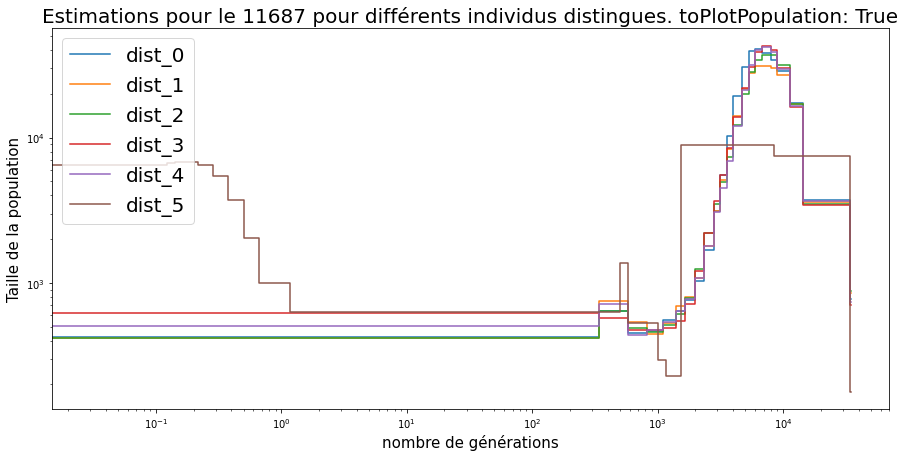

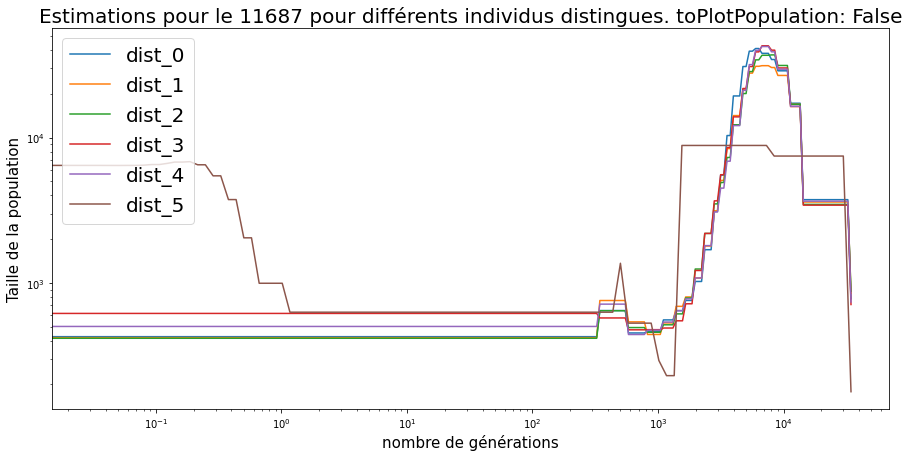

In [66]:
plotDist(11687)
plotDist(11687, False)

### **Conclusion** et commentaires des deux courbes

Lorsque l'on distingue les **2 derniers individus**, on obtient des résultats très **différents** des autres.

La sortie de SMC++ est un peu bizarre, la délimitation des intervalles est bizarre ?

On a fait une fonction **toPlotPopulation** pour transformer les tableaux pour un affichage avec des vrais intervalles. On peut voir la différences entre les deux courbes sur les deux figures précédentes.

Lorsqu'on utiliser la commande `plot` on ne peut pas choisir les intervalles de temps. On peut juste choisir les bornes avec `--timepoints 0 34483` et le nombre de découpes avec `-knots 21`.

On peut produire des fichiers csv correspondant aux courbes avec l'option `-c` de la command `plot`.

**<u>Important</u>: Dans la suite, on va presque systématiquement distinguer l'individu 0 uniquement.**


-------------------------------------

# **III - Partie Adygei**

Dans cette partie, on va comparer le temps d'exécution ainsi que les résultats sur l'estimation de smc, à partir de notre convertisseur se basant sur les matrices de SNP et le convertisseur de smc se basant sur les fichiers VCF.
Les fichiers SNPs et les VCFs représentent les mêmes données, sous deux formats différents.

On se concentre sur le chromosome21, avec 16 individus comme sample.

Voici les fichiers SNPs associées
```
npz_data_pop_ancestral_derived $ ls -l | grep chr21
-rw-r--r-- 1 jerome jerome  5665 Dec  1  2020 Adygei_chr21_1.npz
-rw-r--r-- 1 jerome jerome  6266 Dec  1  2020 Adygei_chr21_10.npz
-rw-r--r-- 1 jerome jerome  6071 Dec  1  2020 Adygei_chr21_11.npz
-rw-r--r-- 1 jerome jerome  3672 Dec  1  2020 Adygei_chr21_12.npz
-rw-r--r-- 1 jerome jerome  5833 Dec  1  2020 Adygei_chr21_13.npz
-rw-r--r-- 1 jerome jerome  4055 Dec  1  2020 Adygei_chr21_14.npz
-rw-r--r-- 1 jerome jerome  5206 Dec  1  2020 Adygei_chr21_15.npz
-rw-r--r-- 1 jerome jerome  7222 Dec  1  2020 Adygei_chr21_16.npz
-rw-r--r-- 1 jerome jerome  5802 Dec  1  2020 Adygei_chr21_2.npz
-rw-r--r-- 1 jerome jerome  6950 Dec  1  2020 Adygei_chr21_3.npz
-rw-r--r-- 1 jerome jerome  6251 Dec  1  2020 Adygei_chr21_4.npz
-rw-r--r-- 1 jerome jerome  6116 Dec  1  2020 Adygei_chr21_5.npz
-rw-r--r-- 1 jerome jerome  5602 Dec  1  2020 Adygei_chr21_6.npz
-rw-r--r-- 1 jerome jerome  5624 Dec  1  2020 Adygei_chr21_7.npz
-rw-r--r-- 1 jerome jerome  6579 Dec  1  2020 Adygei_chr21_8.npz
-rw-r--r-- 1 jerome jerome  6916 Dec  1  2020 Adygei_chr21_9.npz

```

Voici les 16 individus du fichier VCF
```
HGDP01396	HGDP01382	HGDP01403	HGDP01404	HGDP01402	HGDP01383	HGDP01401	HGDP01400	HGDP01384	HGDP01398	HGDP01397	HGDP01388	HGDP01387	HGDP01386	HGDP01385	HGDP01399
```

On commence par vérifier qu'on a bien 16 individus dans nos données, notamment que notre matrice de SNP a 32 lignes correspondant aux deux chromosomes 21 des 16 individus.

On crée aussi une fonction pour charger les données.

In [18]:
def loadfile_Adygei(chrom, i, path="Adygei/snps",form=".npz"):
    file_name = path  +"/Adygei_chr" + str(chrom) + "_" + str(i) + form
    print(file_name)
    data = np.load(file_name)
    return data

In [19]:
data = loadfile_Adygei(21,1)
data['SNP'].shape

Adygei/snps/Adygei_chr21_1.npz


(32, 726)

**On a 32 chromosomes soit 16 individus comment il faut**

In [82]:
 data['POS'].shape

(726,)

**Les dimensions correspondent bien dans notre cas entre la matrice de SNP et de position** 

**On commence par transformer le fichier vcf dans le format accepté par SMC. <br/>
Tout d'abord, Il faut indexer avec tabix deux fichiers avec `tabixFiles` qui sont :**
* le fichier **vcf**
* le fichier **mask**


**Attention:** Il faut exécuter ces commands une seule fois. Car les fichiers une fois compressés sont garder uniquement sous forme d'archive.

Pour récupérer le mask :
```
curl ftp://ngs.sanger.ac.uk/production/hgdp/hgdp_wgs.20190516/accessibility-mask/hgdp_wgs.20190516.mask.bed > hgdp_wgs.20190516.mask.bed
```

In [70]:
def tabixFiles(adygei_folder,vcf_file, mask_file):
    """
    L'objectif de cette fonction c'est de transformer un vcf en smc en utilisant tabix
    adygei_folder : Là où se trouvent nos fichiers
    vcf_file: il faut juste donner le nom du fichier
    mask_file: il faut donner le nom du fichier mask
    
    On travaille sur un dossier Adygei et dans ce dossier Adygei il a un dossier src où se trouvent le fichier mask et vcf,
    c'est dans srx qu'on aura les fichiers .gz et .tbi
    
    le fichier de sortie qui aura convertif le vcf_file en smc sera dans le dossier out et s'applera out.smc
    
    """
    adygei_folder = "Adygei"
    vcf_file = "Adygei_hgdp_wgs.20190516.full.chr21.vcf"
    mask_file = "hgdp_wgs.20190516.mask.bed"
    for file in [vcf_file, mask_file]:
        bgzip = f"bgzip {adygei_folder}/src/{file}"
        tabix = f"tabix -f {adygei_folder}/src/{file}.gz"
        process = subprocess.Popen(bgzip, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
        stdout, stderr = process.communicate()
        #print(stdout, stderr)
        process = subprocess.Popen(tabix, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
        stdout, stderr = process.communicate()
        #print(stdout, stderr)



    vcf2smc = f"smc++ vcf2smc {adygei_folder}/src/{vcf_file}.gz {adygei_folder}/out/out.smc -m {adygei_folder}/src/{mask_file}.gz chr21 HGPD:HGDP01396,HGDP01382,HGDP01403,HGDP01404,HGDP01402,HGDP01383,HGDP01401,HGDP01400,HGDP01384,HGDP01398,HGDP01397,HGDP01388,HGDP01387,HGDP01386,HGDP01385,HGDP01399"
    process = subprocess.Popen(vcf2smc, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    print(f"executing: {vcf2smc}")
    #stdout, stderr = process.communicate()
    #print(stdout, stderr)

In [72]:
adygei_folder = "Adygei"
vcf_file = "Adygei_hgdp_wgs.20190516.full.chr21.vcf"
mask_file = "hgdp_wgs.20190516.mask.bed"

tabixFiles(adygei_folder,vcf_file,mask_file)

executing: smc++ vcf2smc Adygei/src/Adygei_hgdp_wgs.20190516.full.chr21.vcf.gz Adygei/out/out.smc -m Adygei/src/hgdp_wgs.20190516.mask.bed.gz chr21 HGPD:HGDP01396,HGDP01382,HGDP01403,HGDP01404,HGDP01402,HGDP01383,HGDP01401,HGDP01400,HGDP01384,HGDP01398,HGDP01397,HGDP01388,HGDP01387,HGDP01386,HGDP01385,HGDP01399


**Puis on fait une estimation pour vérifier que ça marche bien:**

In [60]:
estimate = f"smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o{adygei_folder}/out/out.smc -o {adygei_folder}"
process = subprocess.Popen(estimate, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
#print(stdout, stderr)

**On fait la même chose mais avec notre fonction adygei_folder, on <u>généralise</u>.**

In [56]:
if "snptosmc" not in os.listdir(adygei_folder):
    os.mkdir(f"{adygei_folder}/snptosmc")
for i in range(1, 17):
    data = np.load(f"{adygei_folder}/snps/Adygei_chr21_{i}.npz")
    SNP = data["SNP"]
    POS = data["POS"]
    SMC = SNPtoSMC(1, SNP, POS)
    header = header_smc("adygei", 1, SNP.shape[0])
    np.savetxt(f"{adygei_folder}/snptosmc/chr21_{i}.smc" , SMC, delimiter=' ', fmt = "%d", header=header)

**On fait l'estimation**

In [16]:
estimate = f"smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o {adygei_folder}/snptosmc/*.smc -o {adygei_folder}/snptosmc"
process = subprocess.Popen(estimate, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
print(stdout, stderr)

**On affiche ces deux estimations**

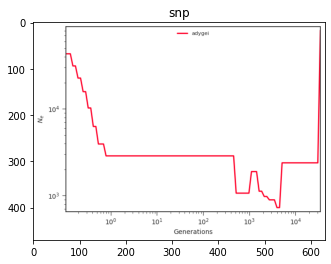

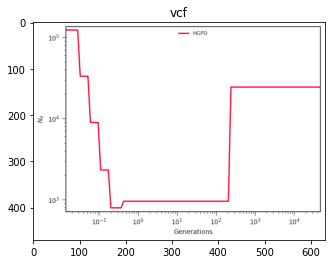

AssertionError: 

In [73]:
plot = f"smc++ plot -c {adygei_folder}/plot.png {adygei_folder}/model.final.json"
process = subprocess.Popen(plot, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
print(stdout, stderr)
plot = f"smc++ plot -c {adygei_folder}/snptosmc/plot.png {adygei_folder}/snptosmc/model.final.json"
process = subprocess.Popen(plot, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
print(stdout, stderr)
figsnp = plt.imread(f"{adygei_folder}/snptosmc/plot.png")
figvcf = plt.imread(f"{adygei_folder}/plot.png")
plt.title(f"snp")
plt.imshow(figsnp)
plt.show()
plt.title(f"vcf")
plt.imshow(figvcf)
plt.show()

#print(f"temps pour snp :{timesnp/60:.1f}min,\npour csv {timecsv/60:.1f}min")

X_smc, Y_smc = loadCSV_plot(f"{adygei_folder}/snptosmc/plot.csv")
X_csv, Y_csv = loadCSV_plot(f"{adygei_folder}/plot.csv")
assert X_smc[0] == X_csv[0]
assert X_smc[-1] == X_csv[-1]
plotError(X_csv, Y_csv, X_smc, Y_smc)

On ne comprend pas pourquoi sur l'estimation à partir du csv, **on n'a pas le bon <u>intervalle</u>**.
Comme les résultats sont différents, on ne peut pas conclure sur le temps de calcul.

Dans la cellule suivante on voit bien qu'on a donné dans la commande précédente l'intervalle `--timepoints 0 34483` .
Sauf qu'avec le vcf convertit avec `vcf2smc` on obtient une estimation entre 0 et 47129.

In [74]:
print(X_smc[-1], X_csv[-1])

34483.0 47129.51010176622


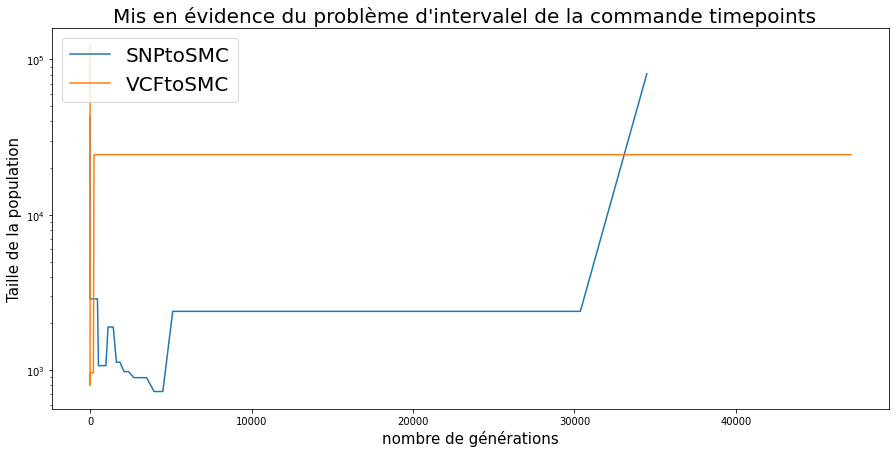

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))


X_smc, Y_smc = loadCSV_plot(f"{adygei_folder}/snptosmc/plot.csv")
X_csv, Y_csv = loadCSV_plot(f"{adygei_folder}/plot.csv")

ax.plot(X_smc, Y_smc, label=f'SNPtoSMC')
ax.plot(X_csv, Y_csv, label=f'VCFtoSMC')
        
    
    
ax.set_title(f"Mis en évidence du problème d'intervalel de la commande timepoints  ", fontdict={'fontsize': 20, 'fontweight': 'medium'})

#ax.set_xscale('log') # J'ai enlevé le log ici expprès pour bien mettre en évidence
ax.set_xlabel("nombre de générations", fontsize = 15)
ax.set_yscale('log')
ax.set_ylabel("Taille de la population", fontsize = 15)

ax.legend(loc=2, prop={'size': 20})


### **Adygei : Conclusion**
Donc on a vu qu'on avait bien 16 individus.
On s'est servi de notre convertiseeur de format SNPtoSMC, on trouve deux choses sur les deux estimsations:
* **`SNPtoSMC`** nous fait bien une estimations entre 0 et 34483 comme demandé dans la commande
* **`VCF2SMC`** nous sort une estimation entre 0 et 47129

Pour la comparaison des **temps d'exécution** entre SNPtoSMC et VCF2SMC n'a pas été faite car on est pas sur le même l'intervalle et ce n'est donc pas pertinent de le faire.

Peut être que les fichiers SMC sont trop différents. En effet, le dataset contient des données incomplètes ou manquantes. Les SNPs ne contient pas de données manquantes, et le parser ne les gère pas. D'une autre part, les fichiers VCF contiennent eux bien les données manquantes et l'information est conservée dans les SMC.

Néanmoins, il aurait été pertinent de comparer les résultats obtenus entre les SMC générés par les VCF et les SNPs. Ce que nous avons fait nous a montré que la comparaison n'était pas possible car il y a eu des problèmes avec les intervalles.

Dans une dernière mesure, on aurait pu comparer les résultats des VCFs avec les résultats du papier SMC++.

----------------------------------------------

# **IV - MSE**

* On s'interesse à calculer la MSE entre deux courbres sur les mêmes intervalles, mais avec des découpages différents.
* On prend donc un découpage de référence (ici le premier donné à la fonction MSE)
* On fait alors la moyenne pondérée de la taille de l'intervalle pour calculer l'erreur entre les deux courbes.

In [36]:
def plotError(trueX, trueY, smcX, smcY, true="true", sample="sample", title="Erreur entre les paramètres démographiques simulés et l'estimation smc++"):
    """
    affiche l'erreur entre 2 courbes et la MSE
    """
    mse, error = MSE(trueX, trueY, smcX, smcY)
    trueX2, trueY2 = toPlotPopulation(trueX, trueY)
    smcX2, smcY2 = toPlotPopulation(smcX, smcY)
    trueX2, error2 = toPlotPopulation(trueX, error)
    fig, ax = plt.subplots(1, 1, figsize=(13, 6))
    ax.plot(trueX2, trueY2, label=true)
    ax.plot(smcX2, smcY2, label=sample)
    ax.plot(trueX2, error2, c='red', label='erreur')
    ax.set_title(f"{title}(MSE:{mse:.2f})")
    ax.set_xlabel("nombre de générations")
    ax.set_ylabel("taille de la population")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    plt.show(fig)
    return mse
    
def MSE(trueX, trueY, smcX, smcY):
    """
    Prend deux estimations sur des intervalles de même taille, mais avec des découpages différents.
    Renvoie l'erreur et la MSE par rapport au découpage des données "true"
    """
    assert trueX[0] == smcX[0]
    assert trueX[-1] == smcX[-1]
    if trueX.size == 21:
        mean = np.array([  9.356916799486353, 9.323732471995893, 9.30978449335766, 9.33964656878526, 9.392022200854134, 9.434276632234456, 9.478676589026684, 9.527309373520657, 9.548713117944578, 9.570245267992675, 9.56750493829087, 9.565466907025149, 9.512536156065158, 9.434521582633796, 9.398206892470371, 9.36322667955644, 9.356504174765535, 9.329018397849097, 9.308910313027818, 9.29553514154116, 9.325170711244999 ])
        std = np.array([ 2.471321525407103, 2.366336778710189, 2.2903378627404347, 2.258010461601245, 2.2503056614138743, 2.248511795954469, 2.233141299490089, 2.248305394343526, 2.2713535468274735, 2.3053573120835487, 2.3326904929251353, 2.3771672792991487, 2.4230819160770842, 2.4615326247187124, 2.487310767175101, 2.506719689289493, 2.52233336318805, 2.531117934134914, 2.5455292792267863, 2.5353273524949906, 2.566884053369089 ])
        trueY = (np.log(trueY) - mean)/std
    else:
        mean = np.zeros(len(trueX))
        std = np.ones(len(trueX))
    
    error = np.zeros(len(trueX))
    for i in range(1, len(trueX)):
        validIds = (smcX >= trueX[i-1]) * (smcX <= trueX[i])
        subX = smcX[validIds]
        subY = smcY[validIds]
        if trueX[i-1] not in subX:
            subX = np.insert(subX, 0, trueX[i-1])
            lastId = np.argwhere(smcX < trueX[i-1])[-1]
            subY = np.insert(subY, 0, smcY[lastId])
        if trueX[i] not in subX:
            subX = np.append(subX, trueX[i])
            subY = np.append(subY, subY[-1])
        # transformer l'intervalle entre 0 et 1
        subX /= (max(subX) - min(subX))
        subX = subX[1:] - subX[:-1]
        # normaliser le sub intervalle
        if trueX.size == 21:
            subY = (np.log(subY)-mean[i-1])/std[i-1]
        # moyenne pondérée de l'intervalle
        error[i-1] = abs(np.dot(subX, subY[:-1]) - trueY[i-1])
    #error[-1] = abs(np.dot(subX[-1], subY[-1]) - trueY[-1])
    error[-1] = abs(subY[-1] - trueY[-1])
    mse = np.sum(np.dot(error, error))/len(error)
    return mse, error

**On teste les fonctions plotError et MSE avec des fonctions simples**

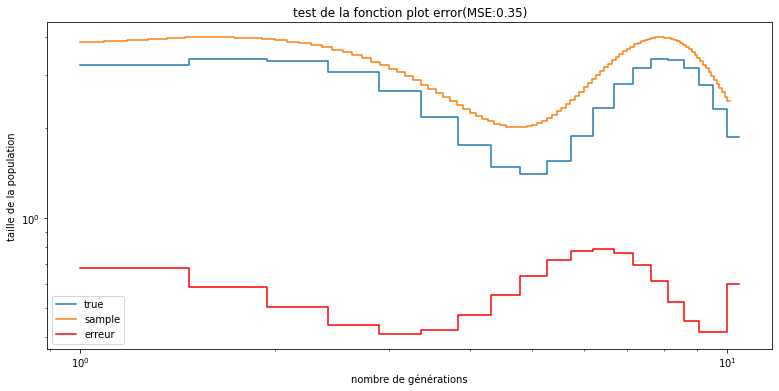

In [55]:
trueX = np.linspace(1, 10, 20)
smcX = np.linspace(1, 10, 100)
trueY = np.sin(trueX) + 2.4
smcY = np.sin(smcX)  + 3
mse = plotError(trueX, trueY, smcX, smcY, title="test de la fonction plot error")

On vérifie surtout que l'erreur est correcte, en plus de tester la fonction plotError.

Ici, la MSE n'a pas trop de sens pour plus de 21 pas de temps. On a simplement fait la moyenne de l'erreur au carré.

### **Conclusion**

La MSE aura du sens seulement sur des courbes à 21 pas de temps.
Les fonctions produisent des résultats qu'on attendait, on s'en servira dans la prochaine partie.

--------------------------------------------------------------------

# **V - Partie comparaison VCF et SMC**

L'objectif de cette partie est de **comparer** notre parser **SNP → SMC** avec le programme vcf2smc de smc++.
On commence par charger les données en mémoire.

In [13]:
directory = "data_hdgp_2mb_vcf"
hdgp_dir = f"{directory}/hdgp"
debug = False
scenario = "46"
dist = 0
smc_dir = f"{directory}/smc"
smc_files_vcf = f"{smc_dir}/scenario_{scenario}/hdgp_{scenario}_*.vcf.smc"
smc_files_snp = f"{smc_dir}/scenario_{scenario}/hdgp_{scenario}_*.snp.smc"

In [256]:
# pour chaque fichier du scénario
for i in range(100):
    indiv = str(i)
    scenario_dir = f"{hdgp_dir}/scenario_{scenario}"
    file = f"{scenario_dir}/hdgp_{scenario}_{indiv}"
    if "smc" not in os.listdir(directory):
        os.mkdir(smc_dir)
    if f"scenario_{scenario}" not in os.listdir(smc_dir):
        os.mkdir(f"{smc_dir}/scenario_{scenario}")
    smc_file_vcf = f"{smc_dir}/scenario_{scenario}/hdgp_{scenario}_{indiv}.vcf.smc"
    smc_file_snp = f"{smc_dir}/scenario_{scenario}/hdgp_{scenario}_{indiv}.snp.smc"

    ## convertir le snp en smc
    data = np.load(f"{file}.npz")
    SNP, POS = data["SNP"], data["POS"]
    N = len(SNP) if len(SNP) % 2 == 0 else len(SNP) - 1
    SMC_snp = SNPtoSMC(dist, SNP, POS)
    header = header_smc("tsk", dist, N)
    np.savetxt(smc_file_snp, SMC_snp, delimiter=' ', fmt = "%d", header=header)

    ## convertir le vcf en smc
    bgzip = f"bgzip {file}.vcf"
    tabix = f"tabix {file}.vcf.gz"
    process = subprocess.Popen(bgzip, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    stdout, stderr = process.communicate()
    #print(bgzip, stdout, stderr)
    process = subprocess.Popen(tabix, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    stdout, stderr = process.communicate()
    #print(tabix, stdout, stderr)
    string = generate_string_vcftosmc("tsk", int(N/2))
    vcf2smc = f"smc++ vcf2smc {file}.vcf.gz {smc_file_vcf} 1 {string}"
    process = subprocess.Popen(vcf2smc, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    stdout, stderr = process.communicate()
    #print(stdout, stderr)

    ## pour debug
    if debug:
        command = f'gunzip {file}.vcf.gz; awk ' + "'{print $2}'" + f" {file}.vcf | tr '\n' ',' | sed -E 's/.*POS,//' | sed -E 's/.$//' "
        process = subprocess.Popen(command, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
        stdout, stderr = process.communicate()
        tab = np.fromstring(stdout, sep=',', dtype=int)
        tab_relative = np.zeros(len(tab), dtype=int)
        tab_relative[0] = tab[0]
        for i in range(1, len(tab)):
            tab_relative[i] = tab[i] - tab[i-1]

        ## récupérer les smc en mémoire
        SMC_vcf = np.loadtxt(f"{smc_file_vcf}", dtype=int)
        minSize = min([SMC_snp.shape[0], SMC_vcf.shape[0]])
        diffs = np.argwhere((SMC_vcf[:minSize] - SMC_snp[:minSize]) > 1)
        if(diffs.size != 0):
            n = np.argwhere((SMC_vcf[:minSize] - SMC_snp[:minSize]) > 1)[0,0] - 2
            m = int(n/2)
            print(tab_relative[m: m+10])
            print(POS[m: m+10])
            print()
            print(SMC_vcf[n:n+10], '\n')
            print(SMC_snp[n:n+10], '\n')
            print((SMC_vcf[:minSize] - SMC_snp[:minSize])[n:n+10])
        else:
            n = 10
            print(SMC_vcf[-n:], '\n')
            print(SMC_snp[-n:], '\n')
            print((SMC_vcf[:minSize] - SMC_snp[:minSize])[-n:])

        print( f"{100*(SMC_vcf[:minSize] != SMC_snp[:minSize]).sum() / SMC_vcf.size:.2f}" , "% de différence")

**En activant la variable debug, on observe entre 6% et 40% de différence. Cela est du aux décallages qu'il y a entre les deux fichiers.
En effet, on s'apercoit que les positions (transformées en positions relatives) du fichier VCF et les positions relatives du fichier SNP ne sont pas tout à fait identiques.**

**De plus, il y a des zéros dans les fichiers.
Sur ce scénario, il n'y a pas de 0 sur le VCF mais c'est n'est pas le cas de tous les scénarios.
Pour les SNP, nous remplaçons tous les 0 par des 1 dans notre fonction SNPtoSMC.**

### **Prédictions sur ces fichiers**

**Malgré les différences entre les fichiers générés, on va quand même faire une estimation, puis comparer les résultats.**

In [14]:
model_vcf = f"{smc_dir}/scenario_{scenario}/model_{scenario}.vcf.json"
model_snp = f"{smc_dir}/scenario_{scenario}/model_{scenario}.snp.json"

plot_vcf = f"{smc_dir}/scenario_{scenario}/plot_{scenario}.vcf.png"
plot_snp = f"{smc_dir}/scenario_{scenario}/plot_{scenario}.snp.png"

csv_snp = f"{smc_dir}/scenario_{scenario}/plot_{scenario}.snp.csv"
csv_vcf = f"{smc_dir}/scenario_{scenario}/plot_{scenario}.vcf.csv"

In [47]:
# pour le fichier snp
estimate = f'smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 {smc_files_snp}'
process = subprocess.Popen(estimate, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
os.rename('model.final.json', model_snp)

# pour le ficher vcf
estimate = f'smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 {smc_files_vcf}'
process = subprocess.Popen(estimate, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
os.rename('model.final.json', model_vcf)

In [13]:
# finalement on enregistre les résultats dans les fichiers csv
plot = f"smc++ plot -c {plot_snp} {model_snp}"
process = subprocess.Popen(plot, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
print(stdout, stderr)

plot = f"smc++ plot -c {plot_vcf} {model_vcf}"
process = subprocess.Popen(plot, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
stdout, stderr = process.communicate()
print(stdout, stderr)

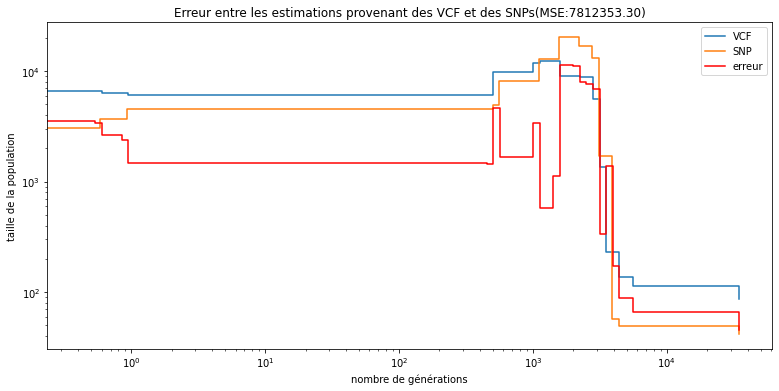

7812353.303927563

In [56]:
# affichage de l'erreur
Xsnp, Ysnp = loadCSV_plot(csv_snp)
Xvcf, Yvcf = loadCSV_plot(csv_vcf)
plotError(Xsnp, Ysnp, Xvcf, Yvcf, "VCF", "SNP", "Erreur entre les estimations provenant des VCF et des SNPs")

L'allure des deux courbes est plutôt similaire. Néanmoins l'erreur reste grande.

Encore une fois, la **MSE n'a pas trop de sens pour plus de 21 pas de temps**. On a simplement fait la moyenne de l'erreur au carré.

### **Conclusion**

Il peut y avoir des décalages sur les fichiers si
* un 1 est remplacé par un 0
* un 2 est remplacé par un 1

On peut affirmer que le parser donne des résultats satisfaisant. Les différences sur les fichiers SMC sont dues aux problèmes d'arrondi du générateur `msprime`.



# **VI: Évaluation de SMC++**

**L'objectif est de voir si SMC++ (à partir des SNP) produit des estimations proches des paramètres démographiques**

**Dans un premier temps, nous trions les scénarios par nombre d'individu de l'échantillon**

In [39]:
snp_dir = "hdgp"
list_scenarios = np.array(os.listdir(snp_dir))
number_individuals = np.zeros(len(list_scenarios), dtype=int)
for i, scenario in enumerate(list_scenarios):
    scenario_dir = f"{snp_dir}/{scenario}"
    file = os.listdir(scenario_dir)[0]
    file = f"{scenario_dir}/{file}"
    data = np.load(file)
    number_individuals[i] = data["SNP"].shape[0]
sorted_indi = np.argsort(number_individuals)
scenario_N = (2*len(list_scenarios))*[0]
scenario_N[::2] = list_scenarios
scenario_N[1::2] = number_individuals
scenario_N = np.reshape(scenario_N, (len(list_scenarios), 2))
print("scénarios contenant le moins d'individus:\n",  scenario_N[sorted_indi][:10])
sorted_scenario = scenario_N[sorted_indi][:,0]

scénarios contenant le moins d'individus:
 [['scenario_18416' '10']
 ['scenario_16844' '10']
 ['scenario_11687' '13']
 ['scenario_7924' '13']
 ['scenario_22972' '13']
 ['scenario_16216' '16']
 ['scenario_2723' '17']
 ['scenario_15320' '18']
 ['scenario_13157' '18']
 ['scenario_12842' '20']]


**On calcule l'erreur et la MSE entre la prédiction et les paramètres démographiques**

scenario_18416: bug de smc++ où les intervalles ne sont pas respectées


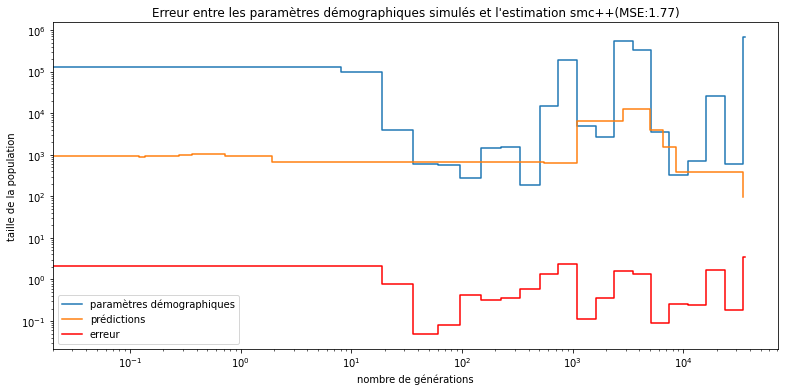

scenario_16844: ok


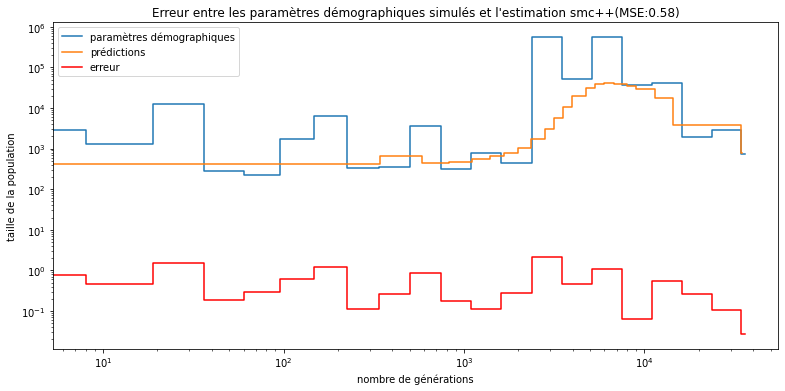

scenario_11687: ok


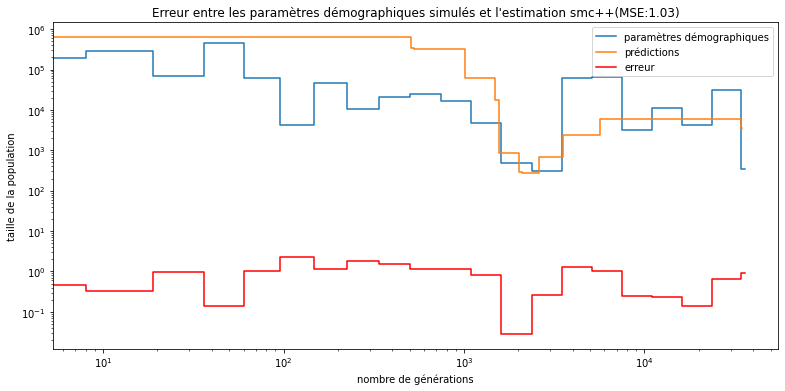

scenario_7924: ok


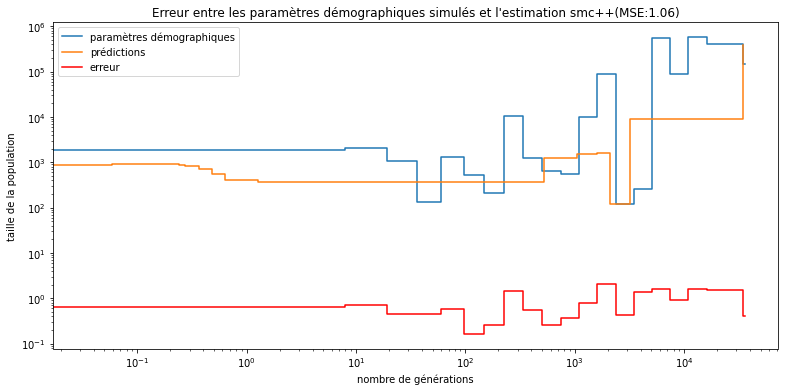

scenario_22972: ok
scenario_16216: bug de smc++ où les intervalles ne sont pas respectées


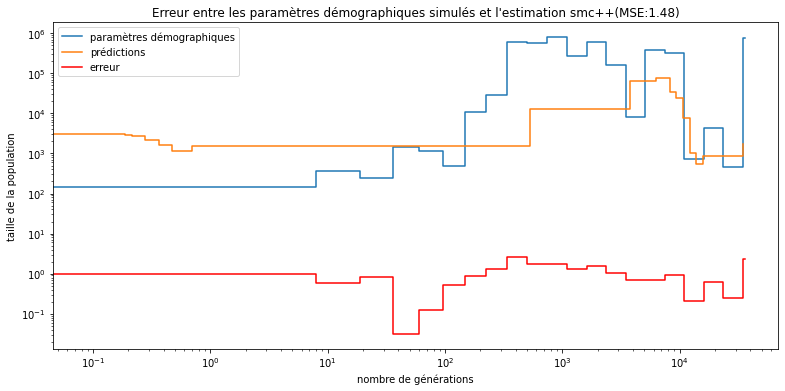

scenario_2723: ok


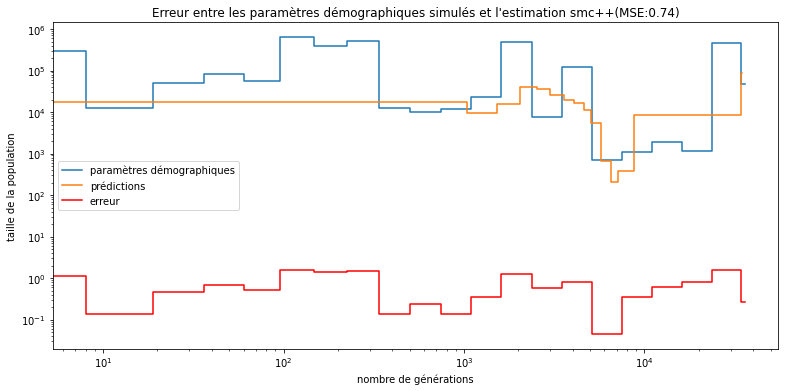

scenario_15320: ok


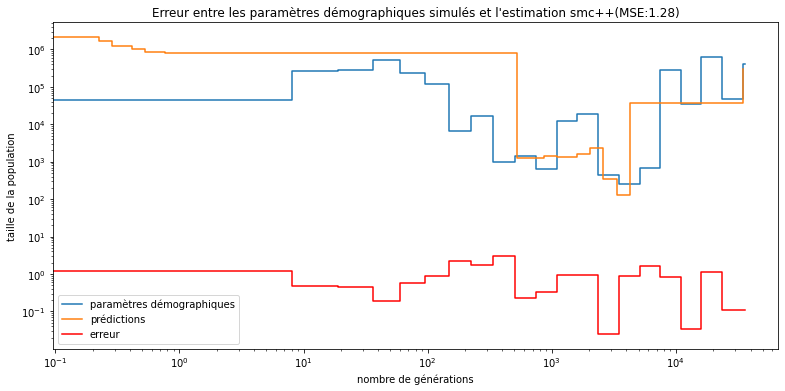

scenario_13157: ok


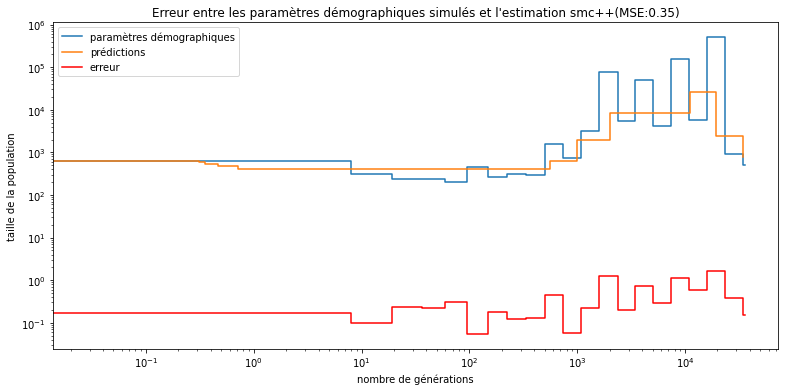

scenario_12842: ok


In [60]:
for scenario in sorted_scenario[:10]:
    sed = f"printf {scenario} | sed -E 's/.*_//'"
    process = subprocess.Popen(sed, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    stdout, stderr = process.communicate()
    scenario = stdout
    try:
        trueX, trueY, smcX, smcY = loadCSV_subsample(scenario = int(scenario))
    except FileNotFoundError:
        print(f"scenario_{scenario}: fichier manquant, on refait l'estimation")
        run_smc_estimate(scenario, display=False, dist=0)
        trueX, trueY, smcX, smcY = loadCSV_subsample(scenario = int(scenario))
    try:
        mse = plotError(trueX, trueY, smcX, smcY, "paramètres démographiques", "prédictions")
    except AssertionError:
        print(f"scenario_{scenario}: bug de smc++ où les intervalles ne sont pas respectées")
        continue
    print(f"scenario_{scenario}: ok")

### **Conclusion**

On a comparé les estimations smc++ (à partir des SNPs) avec les paramètres démographiques, sur les scénarios contenant le moins d'individus.

On a remarqué (encore une fois) le problème des intervalles non respectés par smc++, donc certains scénarios ne sont inclus.

Dans l'ensemble, la MSE reste grande (>1). Sur le dernier scénario testé, on a une MSE plus faire (.35) et deux courbes à l'alure très semblable.

On aurait pu comparer ces résultats à partir des VCF, mais ils n'étaient pas disponibles pour cette partie.

# **VII - Estimations de scenarios et différents tests**
**On a deux hypothèses à vérifer:**
- Premièrement, vérifier si le nombre d'individus change quelque chose
- Deuxièmement, voir l'influence sur les intervalles de temps 

**Je commence par crée des dossiers spéciaux pour retirer des individus dans les scénarios** <br/>
C'est à dire que je ne prendrais dans la partie qui suit que les `dist_max` premières lignes de la matrice de SNP correspondant à `dist_max/2` individus. On va prendre uniquement des valeurs de `dist_max` paires et >=4. 

**PS : En fait c'est la même fonction qu'avant juste ici j'envleve la ligne du assert dist < N/2**

In [10]:
def one_scenario_compressed_lite (dist_max = -1 ,d="scenario_11687", save_dir="smc.gz_files_test"):
    """
    Fonction version "lite": Ici on va prendre au maximum dist_max individus (distingues)
    
    dist_max : nombre d'individus
    save_dir: on travaille donc sur un nouveau jeu de données pour ces tests
    d : c'est le scenario qu'on va aller chercher pour nos tests
    
    """
    if save_dir not in os.listdir():
        os.mkdir(save_dir)
    for file in os.listdir("hdgp/" + d):
        # chargement des données
        data = np.load("hdgp/" + d + "/" + file)
        SNP, POS = data['SNP'], data['POS']
        # remplace tous les 0 de la matrice de positions par des 1
        POS[POS == 0] = 1 
        # on récupère le nombre d'individus (on le suppose pair)
        N = data['SNP'].shape[0]
        N = N if N%2 == 0 else N - 1
        # création du dossier du scénario
        scenario_dir = save_dir + "/" + d +"_individu_"+ str(dist_max)
        
        if d+"_individu_"+ str(dist_max) not in os.listdir(save_dir):
            print("Création du dossier: " + save_dir)
            os.mkdir(scenario_dir)
    
        
        if dist_max != -1:
           
            N = dist_max
            SNP1 = SNP[0:dist_max,:]
            
        r = range(0, int(N/2))
        
        for dist in r:
            # pour chaque individu distingué, on crée un dossier qui contient les fichiers smc associés
            
            dist_dir = scenario_dir + "/" + "dist_" + str(dist)
            if "dist_" + str(dist) not in os.listdir(scenario_dir):
                os.mkdir(dist_dir)
                
            SMC = SNPtoSMC(dist, SNP1, POS)
            filename = dist_dir + "/" + file + str(dist) + ".smc.gz"
            header = header_smc("hdgp", dist, N)
            np.savetxt(filename , SMC, delimiter=' ', fmt = "%d", header=header)
           
            


In [ ]:
Petit test ici pour vérifier qu'on prends bien les 4 

In [11]:
#one_scenario_compressed_lite(dist_max = 4, d = "scenario_8883")

**Ces boucles for vont nous crée des fichiers smc en ne prenant que les 4,6 ou 8 premières lignes des matrices de snp, correspondant donc à 2,3 et 4 individus au total. <br/>
L'objectif ici est de réduire le nombre d'individus pour faire des tests rapides avec smc**

In [12]:
"""
for i in [4,6,8]:
    one_scenario_compressed_lite(dist_max = i, d = "scenario_29877")
"""

In [13]:
"""
for i in [4,6,8]:
    one_scenario_compressed_lite(dist_max = i, d = "scenario_13949")
"""

**Information**: Finalement on se sert principalement de la fonction `run_Test` plus bas car plus pratique

In [14]:
def run_smc_estimate_reduit(scenario , file_dir= "smc.gz_files_test" ,out_dir="out_test", display=False):
    
    scenario_dir = f"{file_dir}/{scenario}"
    scenario_out_dir = f"{out_dir}/{scenario}"    
    
    if out_dir not in os.listdir():
        os.mkdir(out_dir)
    if scenario not in os.listdir(out_dir):
        os.mkdir(scenario_out_dir)
    for dist in os.listdir(scenario_dir):
        print(dist)
        scenario_out_dist_dir = f"{scenario_out_dir}/{dist}"
        if dist not in os.listdir(scenario_out_dir):
            os.mkdir(scenario_out_dist_dir)
        
        command_estimate = f'smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o {scenario_out_dist_dir} {scenario_dir}/{dist}/*.gz'
        command_plot = f'smc++ plot {scenario_out_dist_dir}/plot.png {scenario_out_dist_dir}/model.final.json' 
        print(f"running : {command_estimate}")
        # estimate
        process = subprocess.Popen(command_estimate, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
        stdout, stderr = process.communicate()
        if(display):
            print(stdout, stderr)
        # plot the result
        
        process = subprocess.Popen(command_plot, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()
        if display:
            print(stdout, stderr)
        
        
        

**On lance des estimations pour les différents scenarios qui ont au plus 2,3 et 4 individus:**

In [86]:
dist_max = 4
scenario=8883
dist = 0
tab_indiv = [4,6,8]

In [18]:
def run_Test(scenario,tab_indiv):
    """
    Pour un scenario donné on fait deux choses:
    1- On crée un répertoire correspondant à un scnario en prenant que 
    les dist_max correspondant aux valeurs normalement paires et =>4 de tab_indiv
    
    2- On fait direct une estimation à l'aide de la fonction run_smc_estimate_reduit
    
    """
    for i in tab_indiv:
        one_scenario_compressed_lite(dist_max = i, d = "scenario_"+str(scenario))
        run_smc_estimate_reduit("scenario_"+str(scenario)+'_individu_'+str(i))

In [19]:
run_Test(8883,tab_indiv)

dist_0
running : smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o out_test/scenario_8883_individu_4/dist_0 smc.gz_files_test/scenario_8883_individu_4/dist_0/*.gz
dist_1
running : smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o out_test/scenario_8883_individu_4/dist_1 smc.gz_files_test/scenario_8883_individu_4/dist_1/*.gz
dist_0
running : smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o out_test/scenario_8883_individu_6/dist_0 smc.gz_files_test/scenario_8883_individu_6/dist_0/*.gz
dist_1
running : smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o out_test/scenario_8883_individu_6/dist_1 smc.gz_files_test/scenario_8883_individu_6/dist_1/*.gz
dist_2
running : smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o out_test/scenario_8883_individu_6/dist_2 smc.gz_files_test/scenario_8883_individu_6/dist_2/*.gz
Création du dossier: smc.gz_files_test
dist_0
running : smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o out_test/scenario_8883_in

In [20]:
run_Test(13949,tab_indiv) # scenario où on a eu un bug

dist_0
running : smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o out_test/scenario_13949_individu_4/dist_0 smc.gz_files_test/scenario_13949_individu_4/dist_0/*.gz
dist_1
running : smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o out_test/scenario_13949_individu_4/dist_1 smc.gz_files_test/scenario_13949_individu_4/dist_1/*.gz
dist_0
running : smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o out_test/scenario_13949_individu_6/dist_0 smc.gz_files_test/scenario_13949_individu_6/dist_0/*.gz
dist_1
running : smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o out_test/scenario_13949_individu_6/dist_1 smc.gz_files_test/scenario_13949_individu_6/dist_1/*.gz
dist_2
running : smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o out_test/scenario_13949_individu_6/dist_2 smc.gz_files_test/scenario_13949_individu_6/dist_2/*.gz
dist_0
running : smc++ estimate 1.45e-08 --knots 21 --timepoints 0 34483 -o out_test/scenario_13949_individu_8/dist_0 smc.gz_files

Maintenant il nous reste plus qu'à produire le fichier csv et éventuellement l'image produite par smc

In [76]:
def run_Plot_Indiv(scenario,tab_indiv):
    """
    scenario: numero du scenario qu'on a crée juste avant pour nos tests à l'aide de la fonction run_Test
    tab_indiv: ça va être le nombre d'individus choisi
    """
    
    for dist_max in tab_indiv:
        for dist in range(0,int(dist_max/2)):
            model= f"out_test/scenario_{scenario}_individu_{dist_max}/dist_{dist}/model.final.json"
            png = f"out_test/scenario_{scenario}_individu_{dist_max}/dist_{dist}/plot.png"
            print(png)

            plot = f"smc++ plot -c {png} {model}"
            process = subprocess.Popen(plot, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
            stdout, stderr = process.communicate()
            #print(stdout, stderr)
            
            

In [77]:
run_Plot_Indiv(scenario,tab_indiv)

out_test/scenario_8883_individu_4/dist_0/plot.png
out_test/scenario_8883_individu_4/dist_1/plot.png
out_test/scenario_8883_individu_6/dist_0/plot.png
out_test/scenario_8883_individu_6/dist_1/plot.png
out_test/scenario_8883_individu_6/dist_2/plot.png
out_test/scenario_8883_individu_8/dist_0/plot.png
out_test/scenario_8883_individu_8/dist_1/plot.png
out_test/scenario_8883_individu_8/dist_2/plot.png
out_test/scenario_8883_individu_8/dist_3/plot.png


In [78]:
run_Plot_Indiv(13949,tab_indiv)

out_test/scenario_13949_individu_4/dist_0/plot.png
out_test/scenario_13949_individu_4/dist_1/plot.png
out_test/scenario_13949_individu_6/dist_0/plot.png
out_test/scenario_13949_individu_6/dist_1/plot.png
out_test/scenario_13949_individu_6/dist_2/plot.png
out_test/scenario_13949_individu_8/dist_0/plot.png
out_test/scenario_13949_individu_8/dist_1/plot.png
out_test/scenario_13949_individu_8/dist_2/plot.png
out_test/scenario_13949_individu_8/dist_3/plot.png


In [121]:
def plot_Test_scenario(scenario,tab_indiv,select_dist=-1,title=""):
    """
    Nous fonction qui va simplement nous permettre d'afficher des courbes
    """
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))

    for dist_max in tab_indiv:
        for dist in range(0,int(dist_max/2)):
            if select_dist == -1:
                csv = f"out_test/scenario_{scenario}_individu_{dist_max}/dist_{dist}/plot.csv"
                X, Y = loadCSV_plot(csv)
                X, Y = toPlotPopulation(X,Y)
                ax.plot(X, Y, label=f'max_{dist_max}_dist_{dist}')
            elif dist in select_dist:
                csv = f"out_test/scenario_{scenario}_individu_{dist_max}/dist_{dist}/plot.csv"
                X, Y = loadCSV_plot(csv)
                X, Y = toPlotPopulation(X,Y)
                ax.plot(X, Y, label=f'max_{dist_max}_dist_{dist}')
    
    if title =="":
        ax.set_title(f"Comparaison entre différents nombre d'individus pour le scenario {scenario} ", fontdict={'fontsize': 20, 'fontweight': 'medium'})
    else:
        ax.set_title(title, fontdict={'fontsize': 20, 'fontweight': 'medium'})

    ax.set_xlabel("nombre de générations", fontsize = 15)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel("Taille de la population", fontsize = 15)
    ax.legend(loc=2, prop={'size': 20})

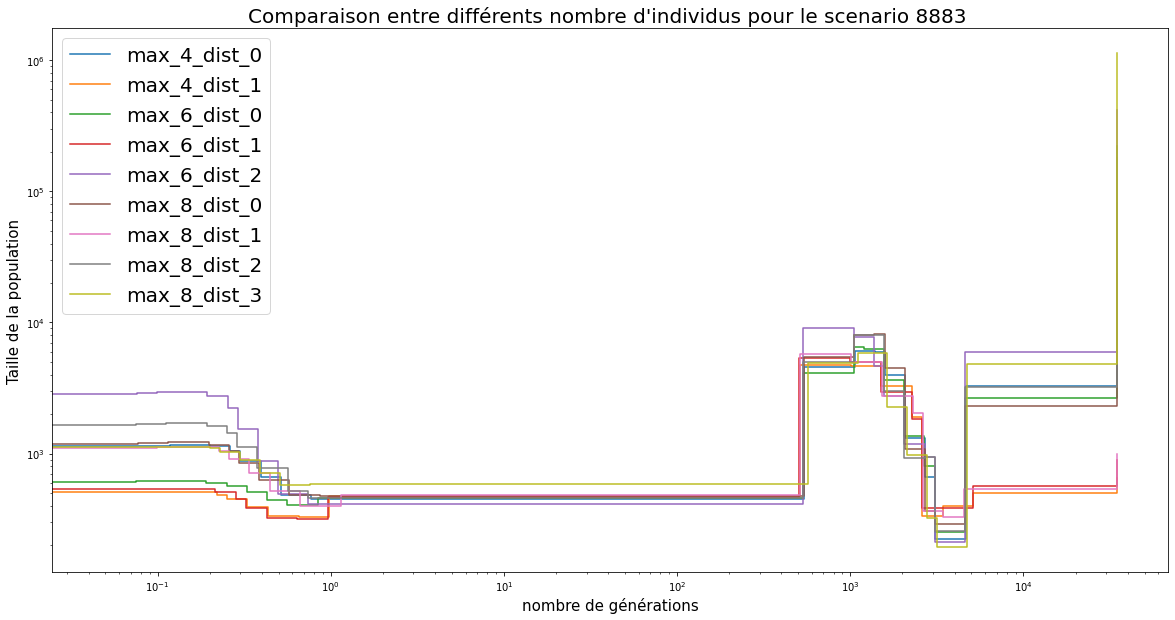

In [122]:
plot_Test_scenario(8883,tab_indiv)

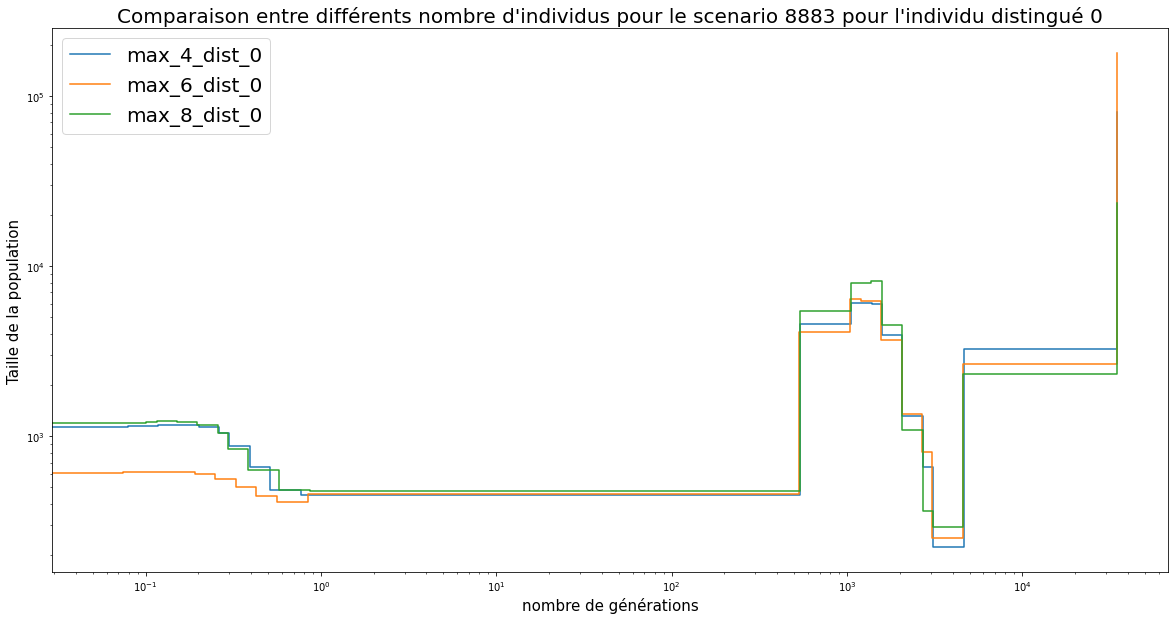

In [123]:
plot_Test_scenario(8883,tab_indiv,[0],f"Comparaison entre différents nombre d'individus pour le scenario {scenario} pour l'individu distingué 0")

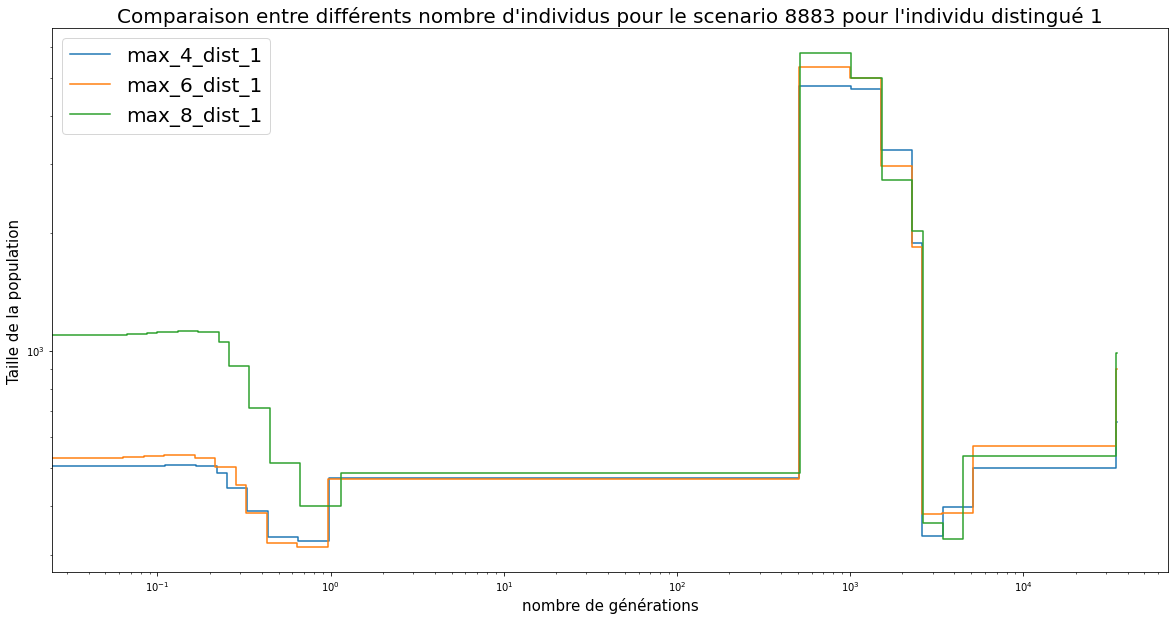

In [124]:
plot_Test_scenario(8883,tab_indiv,[1],f"Comparaison entre différents nombre d'individus pour le scenario {scenario} pour l'individu distingué 1")

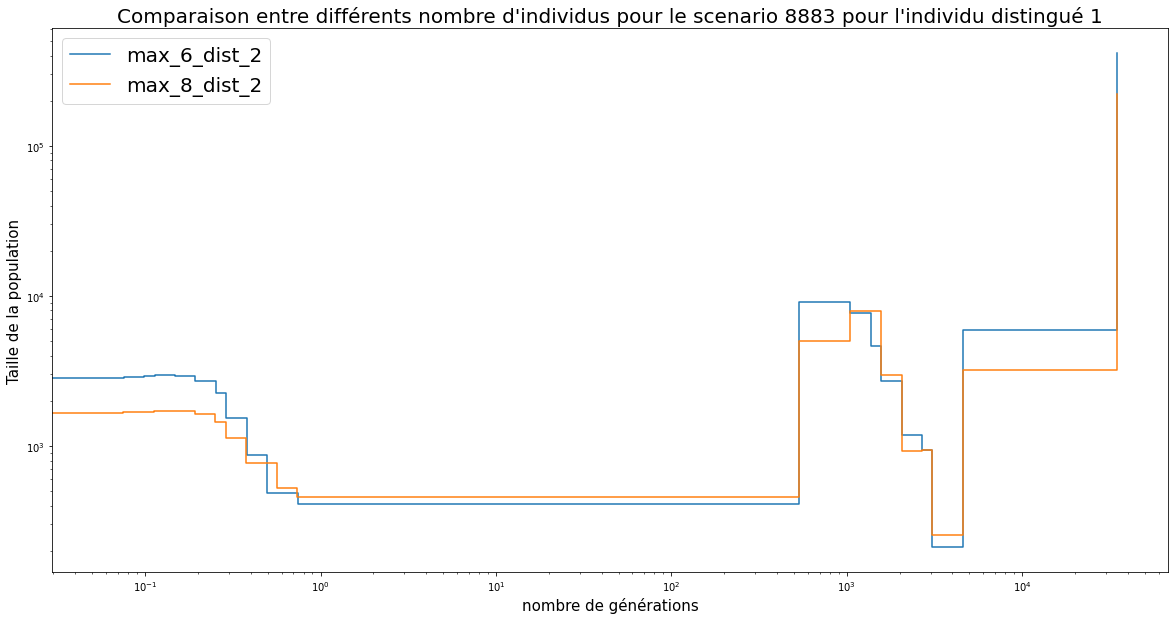

In [125]:
plot_Test_scenario(8883,tab_indiv,[2],f"Comparaison entre différents nombre d'individus pour le scenario {scenario} pour l'individu distingué 1")

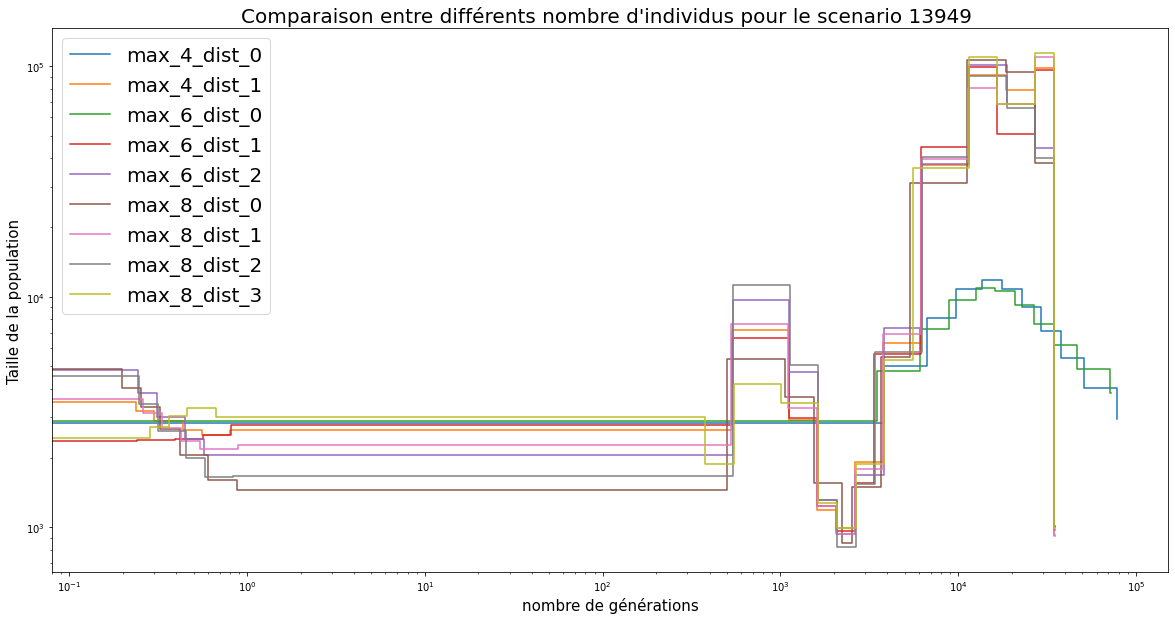

In [126]:
plot_Test_scenario(13949,tab_indiv)

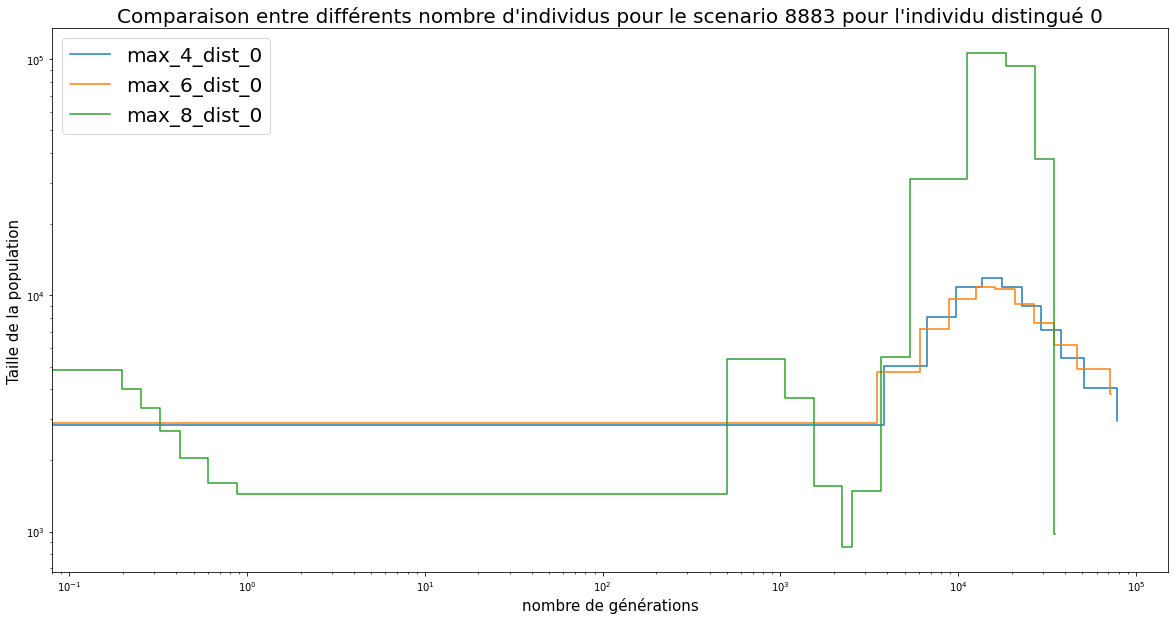

In [127]:
plot_Test_scenario(13949,tab_indiv,[0],f"Comparaison entre différents nombre d'individus pour le scenario {scenario} pour l'individu distingué 0")

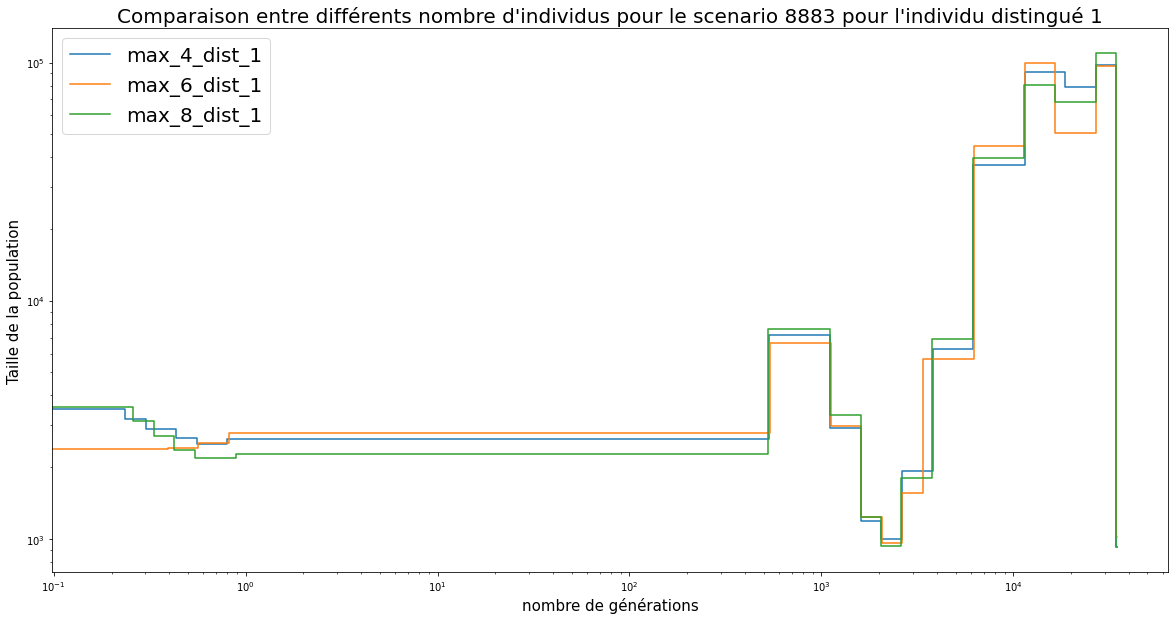

In [128]:
plot_Test_scenario(13949,tab_indiv,[1],f"Comparaison entre différents nombre d'individus pour le scenario {scenario} pour l'individu distingué 1")

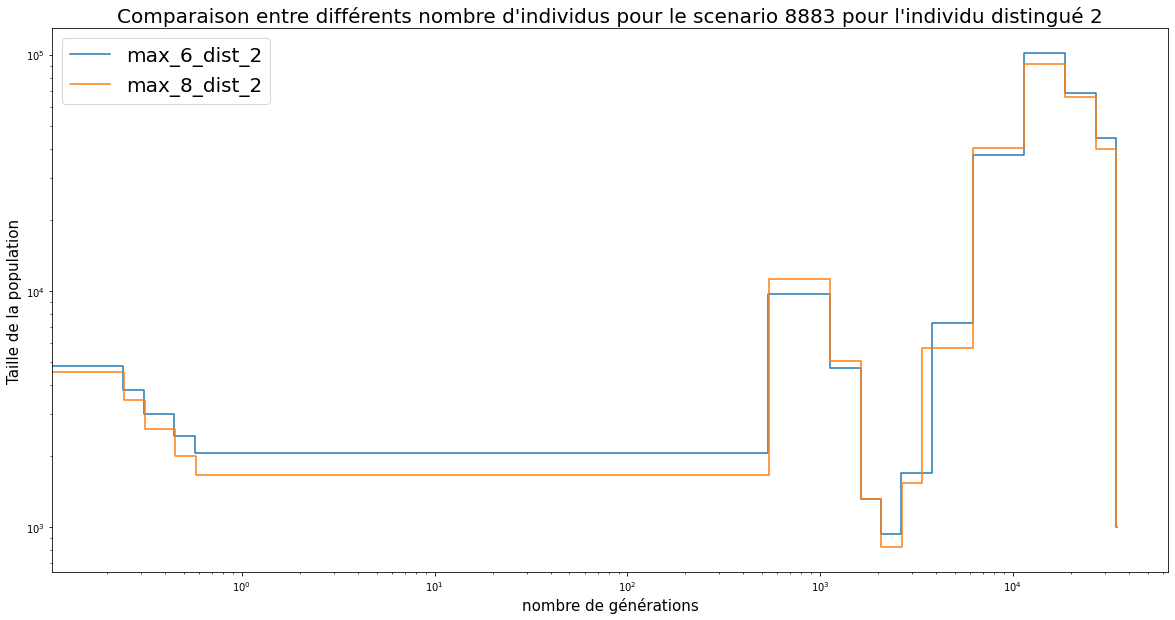

In [129]:
plot_Test_scenario(13949,tab_indiv,[2],f"Comparaison entre différents nombre d'individus pour le scenario {scenario} pour l'individu distingué 2")

**Pour toutes les figures**:
* max_4 par exemple signifie qu'on a pris 4 chromosomes, on a donc raccourci le scenario et pris en comtpe seuelment 2 individus
* dist_0 signifique que l'individu distingué est l'individu 0
* On est sur des échelles logarithmiques en abscisses et ordonnées


**Pour les figures du scenario 8883** :
* On remarque que les scenarios se ressemblenet fortement pour les différents individus distingues

**Pour les figures du scenario 13949** :
* Même constation que le scenario 8883
* Pour l'individu distingue 0, on a un problème dans l'intervalle avec `--timepoints 0 34483`

# Conclusion:
Dans cette partie on a essayé de montrer deux choses:
* En fonction du nombre d'individus qu'on utilise dans la population, sur ce peu jeu de données on ne voit pas grand chose
* Le bug a disparu, j'ai pris un screen, on ne comprends pas pourquoi... => Sachant qu'entre deux runs, parfois c'est pas la même approximation qu'on obtient, d'où ça pourrait venir alors ? **EDIT**: Le bug est revenu, on ne connait pas la raison